In [3]:
import os
import joblib
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, r_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

In [4]:
data = pd.read_csv('../data/processed/data.csv')
models = ['Linear Regression', 'Support Vector Machine', 'Random Forest', 'Gradient Boosting', 'Neural Network (MLP)']

In [46]:
def readable_cols(data):
    col_names = {
            'G': 'Games', 'GS': 'Games Started', 'MP': 'Minutes Played', 
            'FG': 'Field Goals', 'FGA': 'Field Goals Attempted', 
            '3P': '3-Point Field Goals', '3PA': '3-Point Field Goals Attempted', 
            '2P': '2-Point Field Goals', '2PA': '2-Point Field Goals Attempted', 
            'FT': 'Free Throws', 'FTA': 'Free Throws Attempted', 
            'ORB': 'Offensive Rebounds', 'DRB': 'Defensive Rebounds', 'TRB': 'Total Rebounds',
            'AST': 'Assists', 'STL': 'Steals', 'BLK': 'Blocks',
            'TOV': 'Turnovers', 'PF': 'Personal Fouls', 'PTS': 'Points',
            'FG%': 'Field Goal %', '3P%': '3-Point Field Goal %', '2P%': '2-Point Field Goal %',
            'eFG%': 'Effective Field Goal %', 'FT%': 'Free Throw %',
            'Salary': 'Salary (M)', 'Cap Maximum': 'Cap Maximum (M)',
            'Pos_C': 'Center', 'Pos_PF': 'Power Forward', 'Pos_PG': 'Point Guard', 'Pos_SF': 'Small Forward', 'Pos_SG': 'Shooting Guard',
            'Rating': '2K Rating'
        }
    return data.rename(columns=col_names)

### Exploratory Data Analysis

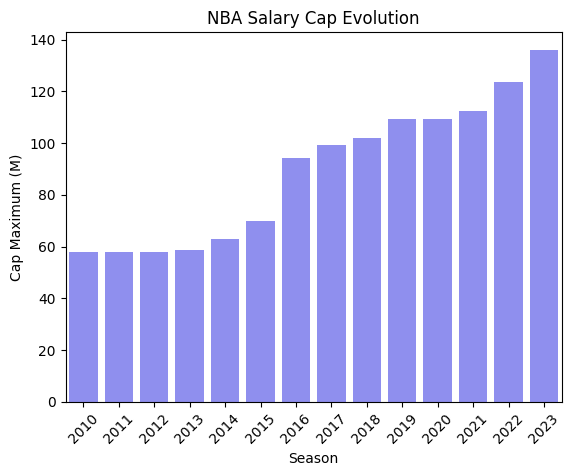

In [94]:
def plot_salary_cap(data):
    plt.xticks(rotation=45)
    plt.ylabel('Cap Maximum (M)');
    sns.barplot(data=data,x='Season',y='Cap Maximum', color='b', alpha=0.5).set(title='NBA Salary Cap Evolution')

plot_salary_cap(data)

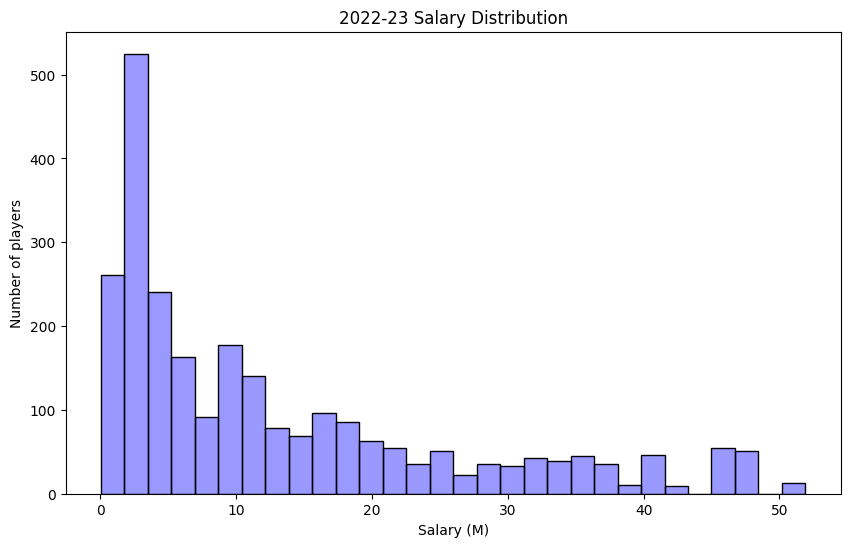

In [15]:
# 2023 Salary distribution
def plot_salary_distribution(data):
    plt.figure(figsize=(10,6))
    hist_kws={'edgecolor':'black', 'color':'b', 'alpha':0.4,'linewidth':1}
    sns.histplot(data=data,x='Salary',bins=30, **hist_kws).set(title='2022-23 Salary Distribution')
    plt.xlabel('Salary (M)')
    plt.ylabel('Number of players')

plot_salary_distribution(data)

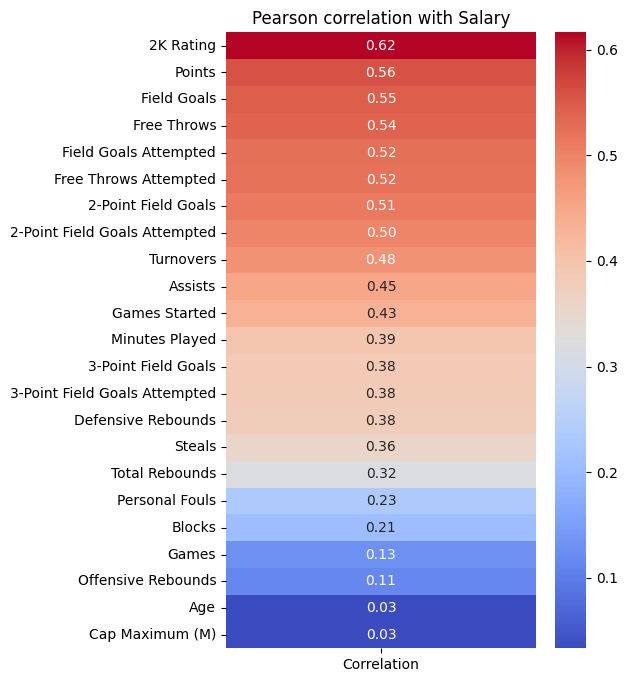

In [49]:
# Plot correlation of other features with Salary
def plot_corr_matrix(data):
    col = data['Salary']
    exclude = ['Salary', 'FT%' ,'3P%', '2P%', 'FG%', 'eFG%', 'Season', 'Player', 'Pos_C', 'Pos_PF', 'Pos_PG', 'Pos_SF', 'Pos_SG', 'Salary Cap %']
    rest = readable_cols(data.loc[:, ~data.columns.isin(exclude)])
    corr = rest.corrwith(col).to_frame().rename(columns={0: 'Correlation'}).sort_values(by='Correlation', ascending=False)
    plt.figure(figsize=(5,8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Pearson correlation with Salary')
    plt.show()

plot_corr_matrix(data.select_dtypes(include=[np.number]))

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_70512\419870865.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos.rename(columns={'Pos_C': 'Center', 'Pos_PF': 'Power Forward', 'Pos_PG': 'Point Guard', 'Pos_SF': 'Small Forward', 'Pos_SG': 'Shooting Guard'}, inplace=True)
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_70512\419870865.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['Position'] = pos.idxmax(axis=1)
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_70512\419870865.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

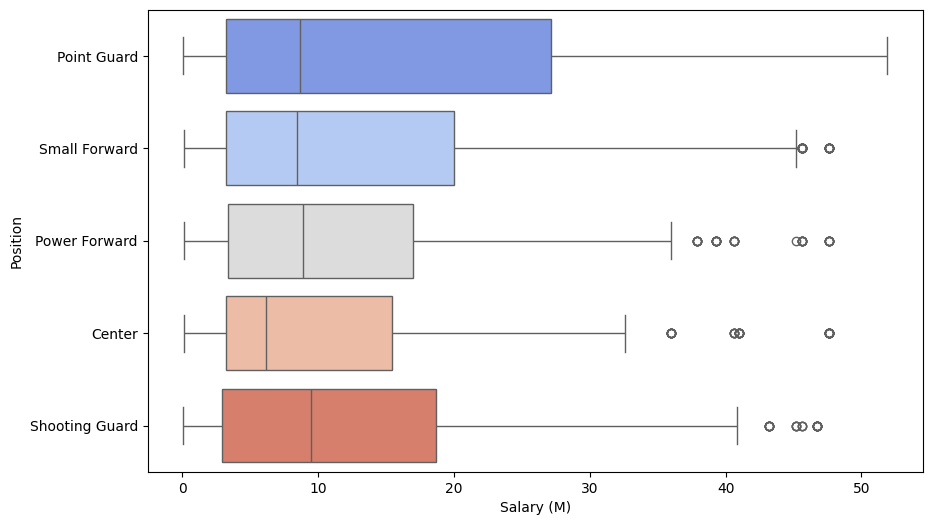

In [62]:
def salary_by_position(data):
    plt.figure(figsize=(10,6))

    # Remove dummies for position, keep only one column, merge 'Pos_C', 'Pos_PF', 'Pos_PG', 'Pos_SF', 'Pos_SG' into 'Position'
    pos = data[['Pos_C', 'Pos_PF', 'Pos_PG', 'Pos_SF', 'Pos_SG']].rename(columns={'Pos_C': 'Center', 'Pos_PF': 'Power Forward', 'Pos_PG': 'Point Guard', 'Pos_SF': 'Small Forward', 'Pos_SG': 'Shooting Guard'})
    pos['Position'] = pos.idxmax(axis=1)
    pos['Salary'] = data['Salary']

    sns.boxplot(data=pos, x='Salary', y='Position', palette='coolwarm', linewidth=1)
    
    plt.xlabel('Salary (M)')
    plt.ylabel('Position')

salary_by_position(data)


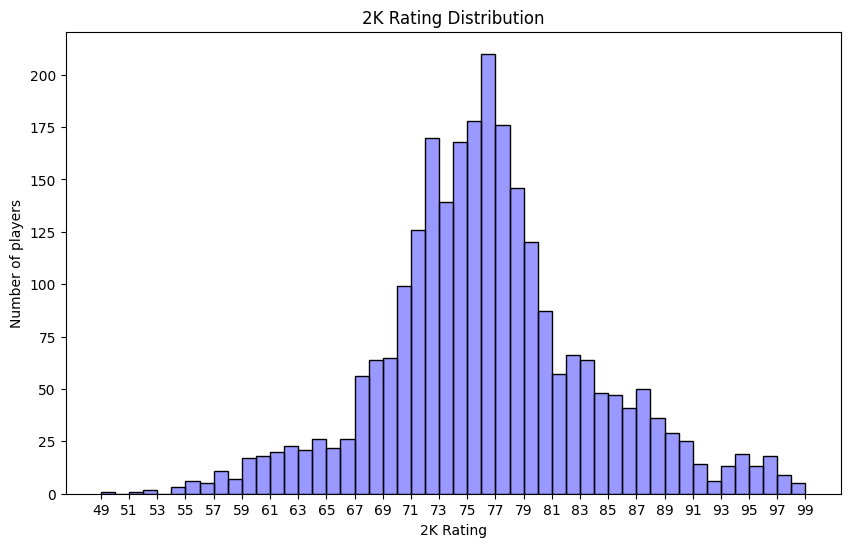

In [77]:
def plot_2k_rating(data):
    plt.figure(figsize=(10,6))
    sns.histplot(data=data,x='Rating',bins=50, color='b', alpha=0.4).set(title='2K Rating Distribution')
    # Add a label per bin, align center
    plt.xticks(np.arange(49, 100, 2))
    plt.xlabel('2K Rating')
    plt.ylabel('Number of players')

plot_2k_rating(data)

### ML Models

In [5]:
# Function for metrics
def func_metrics(y_test, y_pred, metrics, modelo):
    
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),3) # RMSE
    r2 = round(r2_score(y_test, y_pred),3) # R²
    
    dict_met = {'Model': [modelo],
                'RMSE': [rmse],
                'R²': [r2]}
    
    metric = pd.DataFrame(data=dict_met)
    metrics = pd.concat([metrics,metric])
    
    return metrics

In [5]:
def func_scaler(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Store the scaler
    scaler_file = '../models/scaler.sav'
    joblib.dump(scaler, scaler_file)
    
    return X_train, X_test

In [6]:
def split_data(data):
    X = data.drop(columns=['Salary','Player','Season'])
    y = data['Salary']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [7]:
X_train, X_test, y_train, y_test = split_data(data)
scaled_X_train, scaled_X_test = func_scaler(X_train, X_test)

In [20]:
def train_models(scaled_X_train, scaled_X_test, y_train, y_test, models):
    metrics = pd.DataFrame()
    best_params = []

    for model_label in models:
        # Creating instance for each model
        if model_label=='Support Vector Machine':
            param_grid = {'C': [0.001,0.01,0.1,0.5,1,2,5],
                         'kernel': ['linear','rbf','poly'],
                         'gamma': ['scale','auto'],
                         'degree': [2,3,4],
                         'epsilon': [0.1,0.5,1]}
            svr_model = SVR()
            grid = GridSearchCV(svr_model, param_grid)
            grid.fit(scaled_X_train, y_train)
            model = SVR(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif model_label=='Random Forest':
            param_grid = {'n_estimators': [15,25,50,64,100,200],
                         'max_features': [1,2,3,5, None],
                         'bootstrap': [True,False],
                         'oob_score': [True]}
            rfc = RandomForestRegressor()
            grid = GridSearchCV(rfc, param_grid, n_jobs=-1)
            grid.fit(scaled_X_train, y_train)
            model = RandomForestRegressor(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif model_label=='Gradient Boosting':
            param_grid = {'n_estimators': [10,25,50],
                         'learning_rate': [0.01,0.05,0.1,0.5],
                         'max_depth': [3,4,5]}
            gb_model = GradientBoostingRegressor()
            grid = GridSearchCV(gb_model, param_grid)
            grid.fit(scaled_X_train, y_train)
            model = GradientBoostingRegressor(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif model_label=='Neural Network (MLP)':
            param_grid = {'hidden_layer_sizes': [(256, 128), (100,),(200,),(300,)],
                            'activation': ['identity','relu'],
                            'solver': ['lbfgs','sgd','adam'],
                            'alpha': [0.001,0.01, 0.1],
                            'learning_rate_init': [0.001,0.01,0.1]}
            mlp_model = MLPRegressor(max_iter=1000, early_stopping=True)
            grid = GridSearchCV(mlp_model, param_grid, n_jobs=2)
            grid.fit(scaled_X_train, y_train)
            model = MLPRegressor(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif model_label=='Linear Regression':
            model = LinearRegression()
            best_params.append(None)

        model.fit(scaled_X_train, y_train)
        
        # Save the model
        joblib.dump(model, f'../models/{model_label}.sav')
        print(f'{model_label} trained and saved')
        
        y_pred = model.predict(scaled_X_test)
        metrics = func_metrics(y_test, y_pred, metrics, model)
    
    return metrics, best_params


In [ ]:
models = ['Linear Regression', 'Support Vector Machine', 'Random Forest', 'Gradient Boosting', 'Neural Network (MLP)']
metrics, best_params = train_models(scaled_X_train, scaled_X_test, y_train, y_test, models)

In [25]:
best_params

[None,
 {'C': 5, 'degree': 2, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'},
 {'bootstrap': True,
  'max_features': None,
  'n_estimators': 15,
  'oob_score': True},
 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50},
 {'activation': 'relu',
  'alpha': 0.1,
  'hidden_layer_sizes': (300,),
  'learning_rate_init': 0.01,
  'solver': 'lbfgs'}]

In [40]:
metrics

,Model,RMSE,R²
0,LinearRegression(),3.641,0.924
0,"SVR(C=5, degree=2, gamma='auto')",2.413,0.967
0,(DecisionTreeRegressor(random_state=1963620202...,0.986,0.994
0,([DecisionTreeRegressor(criterion='friedman_ms...,0.693,0.997
0,"MLPRegressor(alpha=0.1, hidden_layer_sizes=(30...",0.383,0.999


### Results

In [8]:
# Load the models
rf_model = joblib.load('../models/Random Forest.sav')
gb_model = joblib.load('../models/Gradient Boosting.sav')
mlp_model = joblib.load('../models/Neural Network (MLP).sav')
svr_model = joblib.load('../models/Support Vector Machine.sav')
lr_model = joblib.load('../models/Linear Regression.sav')

final_models = {
    'Linear Regression': lr_model,
    'Support Vector Machine': svr_model,
    'Gradient Boosting': gb_model,
    'Random Forest': rf_model,
    'Neural Network (MLP)': mlp_model,
}


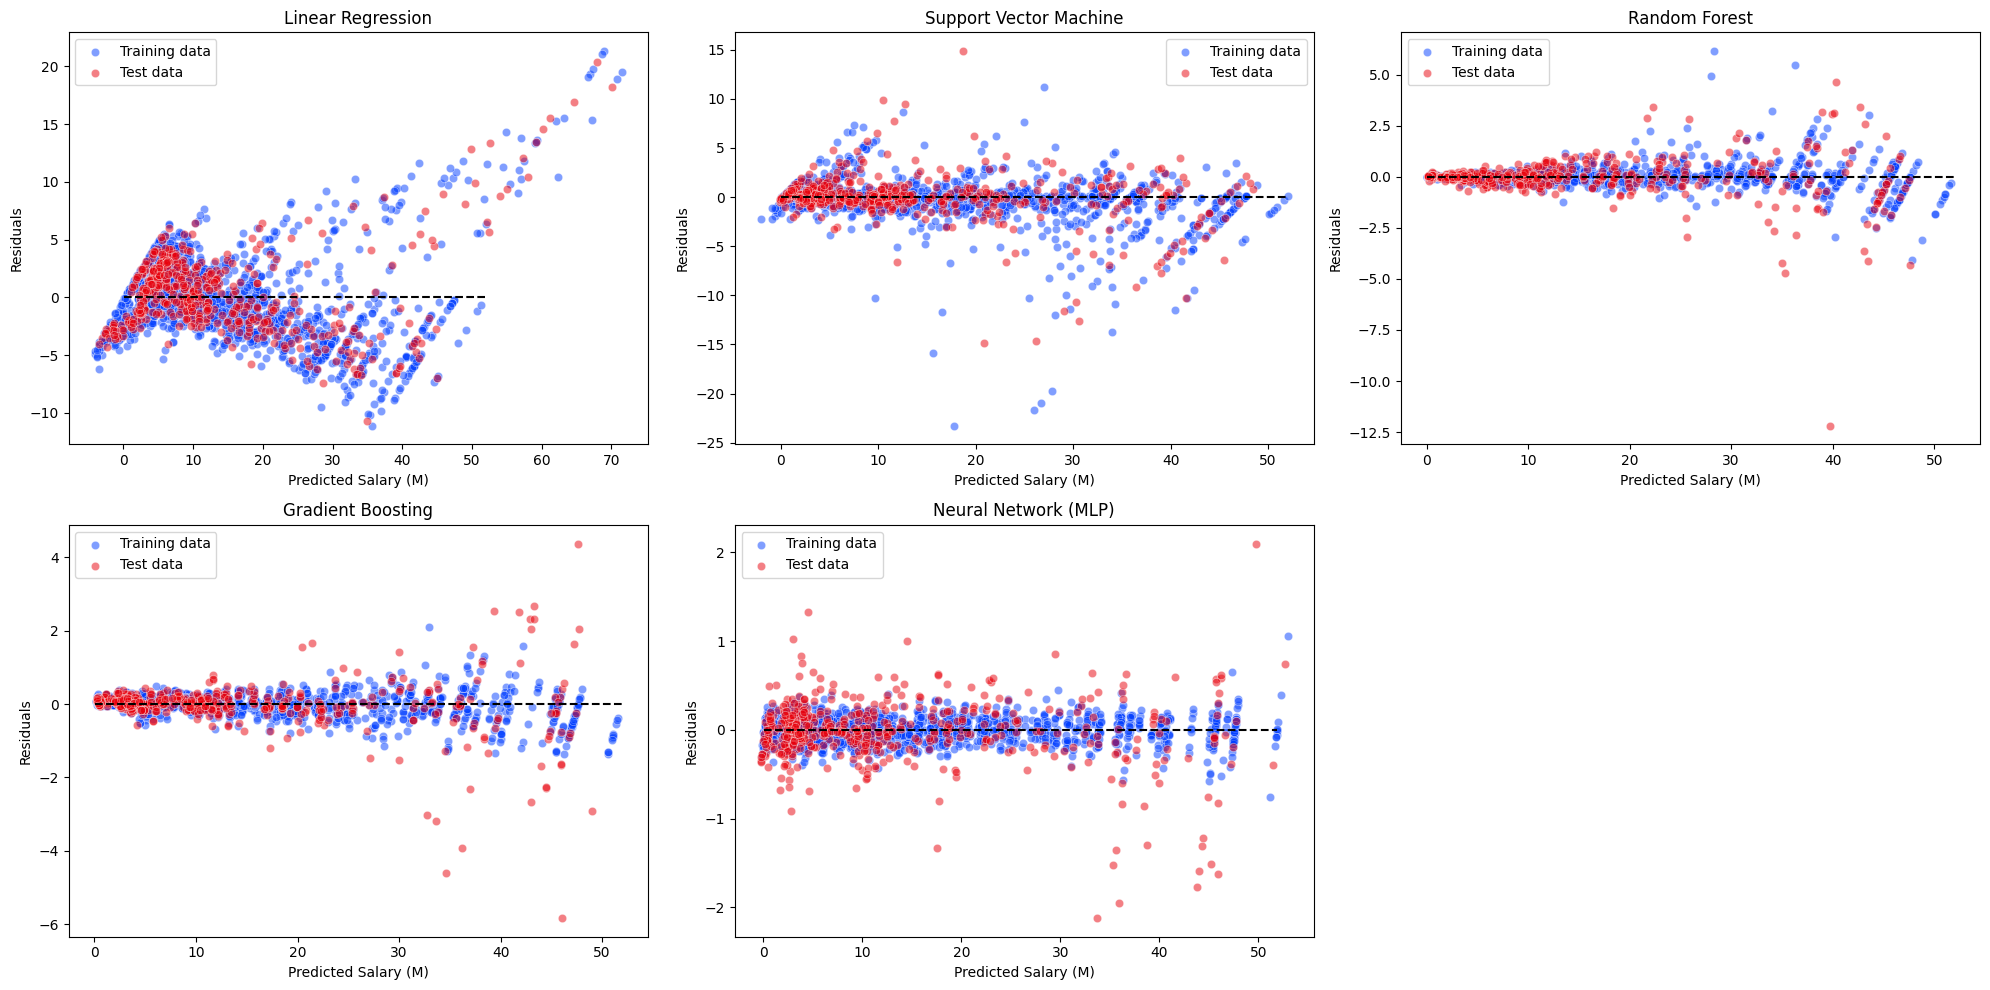

In [96]:
def plot_residuals(x_train, y_train, models, x_test, y_test):
    _, axs = plt.subplots(2, 3, figsize=(20, 10))
    axs = axs.flatten()

    for i, model_label in enumerate(models):
        # Training data predictions
        m = final_models[model_label]
        x = m.predict(x_train)
        sns.scatterplot(x=x, y=x-y_train, ax=axs[i], markers='.', label='Training data', alpha=0.5, color='b')

        # Test data predictions
        x = m.predict(x_test)
        sns.scatterplot(x=x, y=x-y_test, ax=axs[i], markers='.', label='Test data', alpha=0.5, color='r')        
        
        axs[i].hlines(y=0, 
                    xmin=min(y_test.min(), y_train.min()), 
                    xmax=max(y_test.max(), y_train.max()), 
                    colors='black',linestyles='--')
        axs[i].set_title(model_label)
        axs[i].set_xlabel('Predicted Salary (M)')
        axs[i].set_ylabel('Residuals')
        axs[i].legend()

    plt.delaxes(axs[-1])
    plt.tight_layout()
    plt.show()

plot_residuals(scaled_X_train, y_train, models, scaled_X_test, y_test)

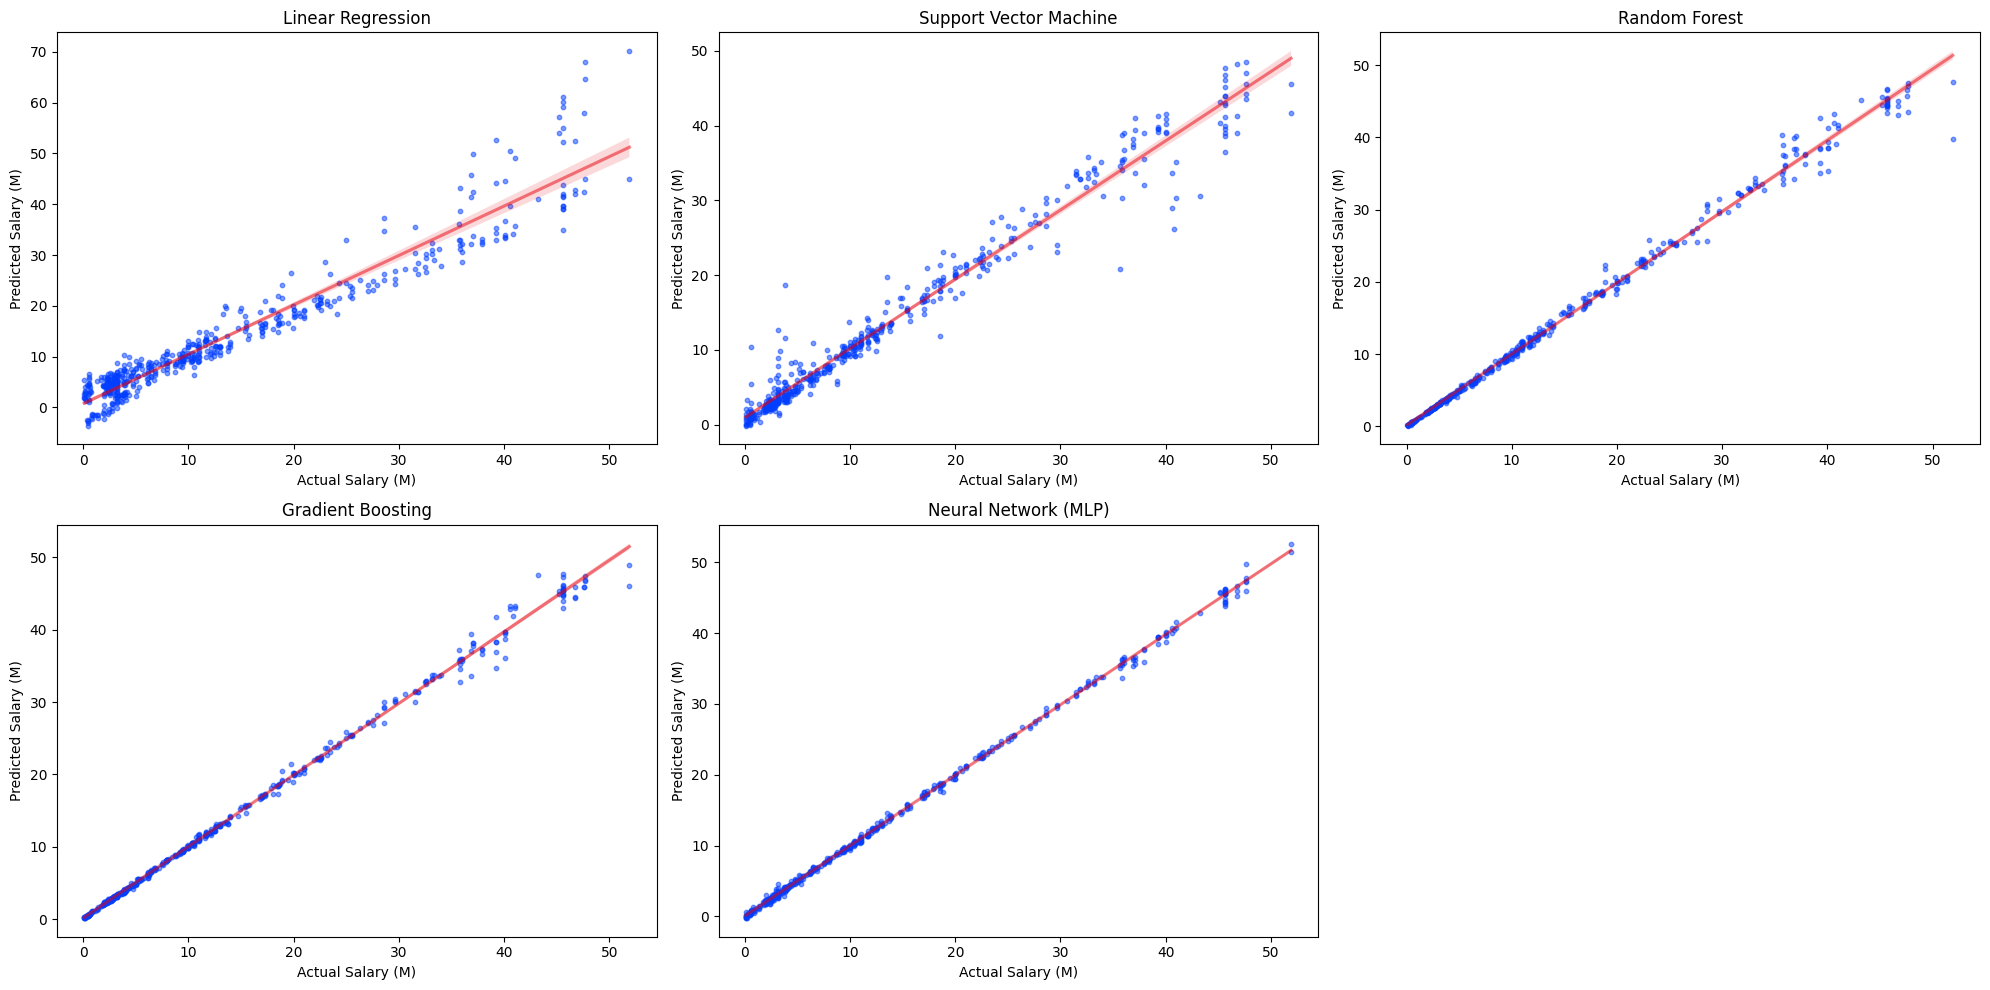

In [135]:
def plot_residuals(x_train, y_train, models, x_test, y_test):
    _, axs = plt.subplots(2, 3, figsize=(20, 10))
    axs = axs.flatten()

    for i, model_label in enumerate(models):
        # Training data predictions
        m = final_models[model_label]

        # Test data predictions
        x = m.predict(x_test)
        # sns.scatterplot(x=y_test, y=x, ax=axs[i], markers='.', label='Test data', alpha=0.5, color='b')        
        sns.regplot(x=y_test, y=x, ax=axs[i], scatter_kws={'s': 10, 'color': 'b', 'alpha':0.5}, line_kws={'color': 'r', 'alpha':0.5})

        axs[i].set_title(model_label)
        axs[i].set_xlabel('Actual Salary (M)')
        axs[i].set_ylabel('Predicted Salary (M)')
        # axs[i].legend()

    plt.delaxes(axs[-1])
    plt.tight_layout()
    plt.show()

plot_residuals(scaled_X_train, y_train, models, scaled_X_test, y_test)

In [90]:
# Predit test data with Random Forest, print worst and best predictions
y_pred = final_models['Neural Network (MLP)'].predict(scaled_X_test)
data_test = data.loc[y_test.index]
data_test['Predicted Salary'] = y_pred.round(3)
data_test['Residuals'] = (y_pred - y_test).round(3)
data_test['Absolute Residuals'] = abs(data_test['Residuals']).round(3)

# Show only Salary, Predicted Salary and Residuals
data_test[['Player','Season','Salary','Predicted Salary','Residuals', 'Absolute Residuals']].sort_values(by='Absolute Residuals', ascending=False).head(10)


,Player,Season,Salary,Predicted Salary,Residuals,Absolute Residuals
532,CJ McCollum,2015,35.802,33.681,-2.121,2.121
353,Kevin Durant,2011,47.649,49.749,2.100,2.100
889,Ben Simmons,2018,37.893,35.944,-1.949,1.949
572,Kawhi Leonard,2015,45.640,43.863,-1.777,1.777
582,LeBron James,2015,47.607,45.978,-1.629,1.629
789,Giannis Antetokounmpo,2017,45.640,44.053,-1.587,1.587
568,Jrue Holiday,2015,36.862,35.343,-1.519,1.519
530,Bradley Beal,2015,46.742,45.230,-1.512,1.512
581,Kyrie Irving,2015,37.037,35.683,-1.354,1.354
1593,Derrick Rose,2021,3.196,4.528,1.332,1.332


In [10]:
import shap

def f(x):
    return final_models['Neural Network (MLP)'].predict(x)

rf_explainer = shap.TreeExplainer(final_models['Random Forest'])
gb_explainer = shap.TreeExplainer(final_models['Gradient Boosting'],)
mlp_explainer = shap.KernelExplainer(f, scaled_X_train[:50,:])

shap_values_rf = rf_explainer.shap_values(scaled_X_test)
shap_values_gb = gb_explainer.shap_values(scaled_X_test)
shap_values_mlp = mlp_explainer.shap_values(scaled_X_test)


100%|██████████| 515/515 [07:01<00:00,  1.22it/s]


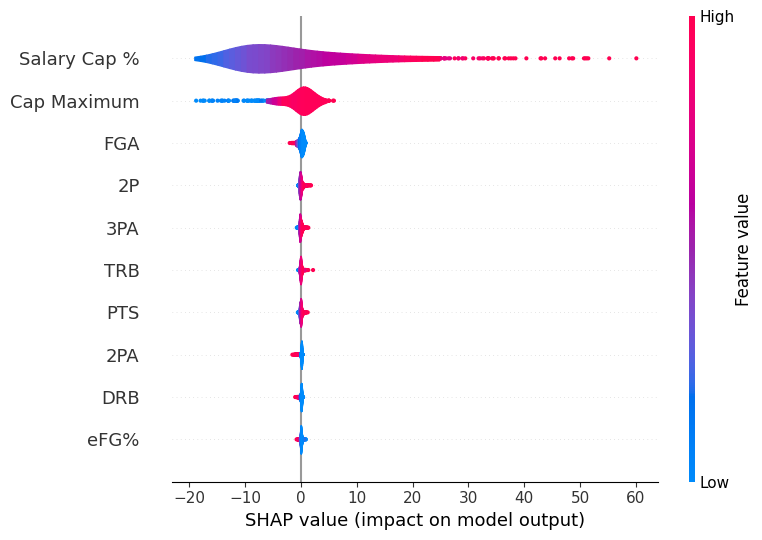

In [13]:
shap.summary_plot(shap_values_mlp, scaled_X_test, feature_names=X_train.columns, plot_type='violin', max_display=10)